$\huge{\color{red}{\text{Connecticut District Learning Models,}}}$ 
<br>
<br>

In [1]:

import pandas
import numpy as np
from sodapy import Socrata
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

***
<br>
<br>

$\huge{\color{blue}{\text{Fetch Table from CT DPH}}}$

In [2]:

client = Socrata("data.ct.gov", None)

results = client.get("5q7h-u2ac", limit=20000)

# Convert to pandas DataFrame
results_df = pandas.DataFrame.from_records(results)    
    
results_df[0:3]

,district_code,district_name,grades_inperson_model,grades_hybrid_model,grades_remote_model,predominant_model,organization_type,reporting_period,update_date,alliance_district,school_start_date,percent_students_fully_remote,total_number_students
0,0010011,Andover School District,"PK, K, g1, g2, g3, g4, g5, g6",N/A,N/A,Most/All Grades Fully In-Person,Public School Districts,"February 8, 2021 - February 12, 2021",2021-02-17T00:00:00.000,NaN,NaN,NaN,NaN
1,0020011,Ansonia School District,"PK, K, g1, g2, g3, g4, g5, g6, g7, g8, g9, g10...",N/A,N/A,Most/All Grades Fully In-Person,Public School Districts,"February 8, 2021 - February 12, 2021",2021-02-17T00:00:00.000,Alliance,NaN,NaN,NaN
2,0030011,Ashford School District,"PK, K, g1, g2, g3, g4, g5, g6, g7, g8",N/A,N/A,Most/All Grades Fully In-Person,Public School Districts,"February 8, 2021 - February 12, 2021",2021-02-17T00:00:00.000,NaN,NaN,NaN,NaN


$\huge{\color{blue}{\text{Predominant Model to 1,0}}}$

In [3]:
results_df = results_df.drop(['district_code', 'school_start_date', 'percent_students_fully_remote', 'total_number_students'], axis=1)
results_df['remote'] = np.where(results_df['predominant_model']=='Most/All Grades Fully Remote', 1, 0)
results_df[0:3]

,district_name,grades_inperson_model,grades_hybrid_model,grades_remote_model,predominant_model,organization_type,reporting_period,update_date,alliance_district,remote
0,Andover School District,"PK, K, g1, g2, g3, g4, g5, g6",N/A,N/A,Most/All Grades Fully In-Person,Public School Districts,"February 8, 2021 - February 12, 2021",2021-02-17T00:00:00.000,NaN,0
1,Ansonia School District,"PK, K, g1, g2, g3, g4, g5, g6, g7, g8, g9, g10...",N/A,N/A,Most/All Grades Fully In-Person,Public School Districts,"February 8, 2021 - February 12, 2021",2021-02-17T00:00:00.000,Alliance,0
2,Ashford School District,"PK, K, g1, g2, g3, g4, g5, g6, g7, g8",N/A,N/A,Most/All Grades Fully In-Person,Public School Districts,"February 8, 2021 - February 12, 2021",2021-02-17T00:00:00.000,NaN,0


In [4]:
results_df['remote_num'] = results_df.grades_remote_model.apply(lambda x: len(x.split(',')))
results_df['hybrid_num'] = results_df.grades_hybrid_model.apply(lambda x: len(x.split(',')))
results_df['inperson_num'] = results_df.grades_inperson_model.apply(lambda x: len(x.split(',')))

In [5]:
#results_df['R'] = results_df.apply(lambda x: 'R' if x[10] > x[11] and x[10] > x[12] else ' ', axis=1)
#results_df['H'] = results_df.apply(lambda x: 'H' if x[11] > x[10] and x[11] > x[12] else ' ', axis=1)
#results_df['I'] = results_df.apply(lambda x: 'I' if x[12] > x[11] and x[12] > x[10] else ' ', axis=1)
#results_df['predom'] = results_df['R'] + results_df['H'] + results_df['I']
results_df['R'] = results_df.apply(lambda x: 1.0 if x[10] > x[11] and x[10] > x[12] else 0, axis=1)
results_df['H'] = results_df.apply(lambda x: 2.0 if x[11] > x[10] and x[11] > x[12] else 0, axis=1)
results_df['I'] = results_df.apply(lambda x: 3.0 if x[12] > x[10] and x[12] > x[11] else 0, axis=1)
results_df['predom'] = results_df[["R", "H", "I"]].max(axis=1)

In [6]:
#results_df[results_df.district_name == "Andover School District"]

$\huge{\color{blue}{\text{Select Districts}}}$


In [7]:
urban_df = results_df.dropna(subset=["alliance_district"])
#urban_df = results_df[results_df.alliance_district.isnull()]
#urban_df = urban_df[urban_df.organization_type == 'Public Charter School Districts']
#urban_df[urban_df.district_name == "Norwalk School District"]


In [8]:
def select_graph_export(TYPE):
    #select all districts of type chosen
    if TYPE == 'Alliance':
        urban_df = results_df.dropna(subset=["alliance_district"])
    elif TYPE == 'Non-Alliance':
        urban_df = results_df[results_df.alliance_district.isnull()]
    elif TYPE == "Charter":
        urban_df = results_df[results_df.organization_type == 'Public Charter School Districts']
    else: print("unrecognized type")
    
    
    districtlist = urban_df.district_name.unique().tolist()
    
    #make a list of the predominant learning model types sorted by date
    datalist = []
    for district in districtlist:
        df = urban_df[urban_df['district_name'] == district].sort_values(by='update_date')
        datalist.append(df['predom'].tolist())
    if TYPE == 'Non-Alliance':
        data = np.array(datalist[:-1])
    else:
        data = np.array(datalist)
    
    #remove the words "School District" from each town
    labels = []
    for district in districtlist:
        labels.append(district.replace(' School District', ''))
    
    #isolate one of the districts to get an ordered list of dates
    bport_df = urban_df[urban_df['district_name'] == districtlist[0]].sort_values(by='update_date')

    weeks = []
    for week in bport_df['update_date'].tolist():
        weeks.append(week[5:10])

    #make graph
    if TYPE == 'Alliance' or TYPE == 'Charter':
        fig, ax = plt.subplots(figsize=(30,30))
    elif TYPE == 'Non-Alliance':
        fig, ax = plt.subplots(figsize=(30,80))
    
    
    im = ax.imshow(data)
    ax.set_xticks(np.arange(len(weeks)))
    ax.set_yticks(np.arange(len(labels)+1))
    ax.set_xticklabels(weeks)
    ax.set_yticklabels(labels)
    plt.setp(ax.get_xticklabels(), rotation=45, size = 10, ha="right",
             rotation_mode="anchor")

    #legend stuff
   
    values = np.unique(data.ravel())
    colors = [ im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    import matplotlib.patches as mpatches
    models = ['no dominant model', 'most grades remote', 'most grades hybrid', 'most grades in person']
    patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=models[i]) ) for i in range(len(models)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    
    plt.savefig(TYPE + '.png')
    plt.show()

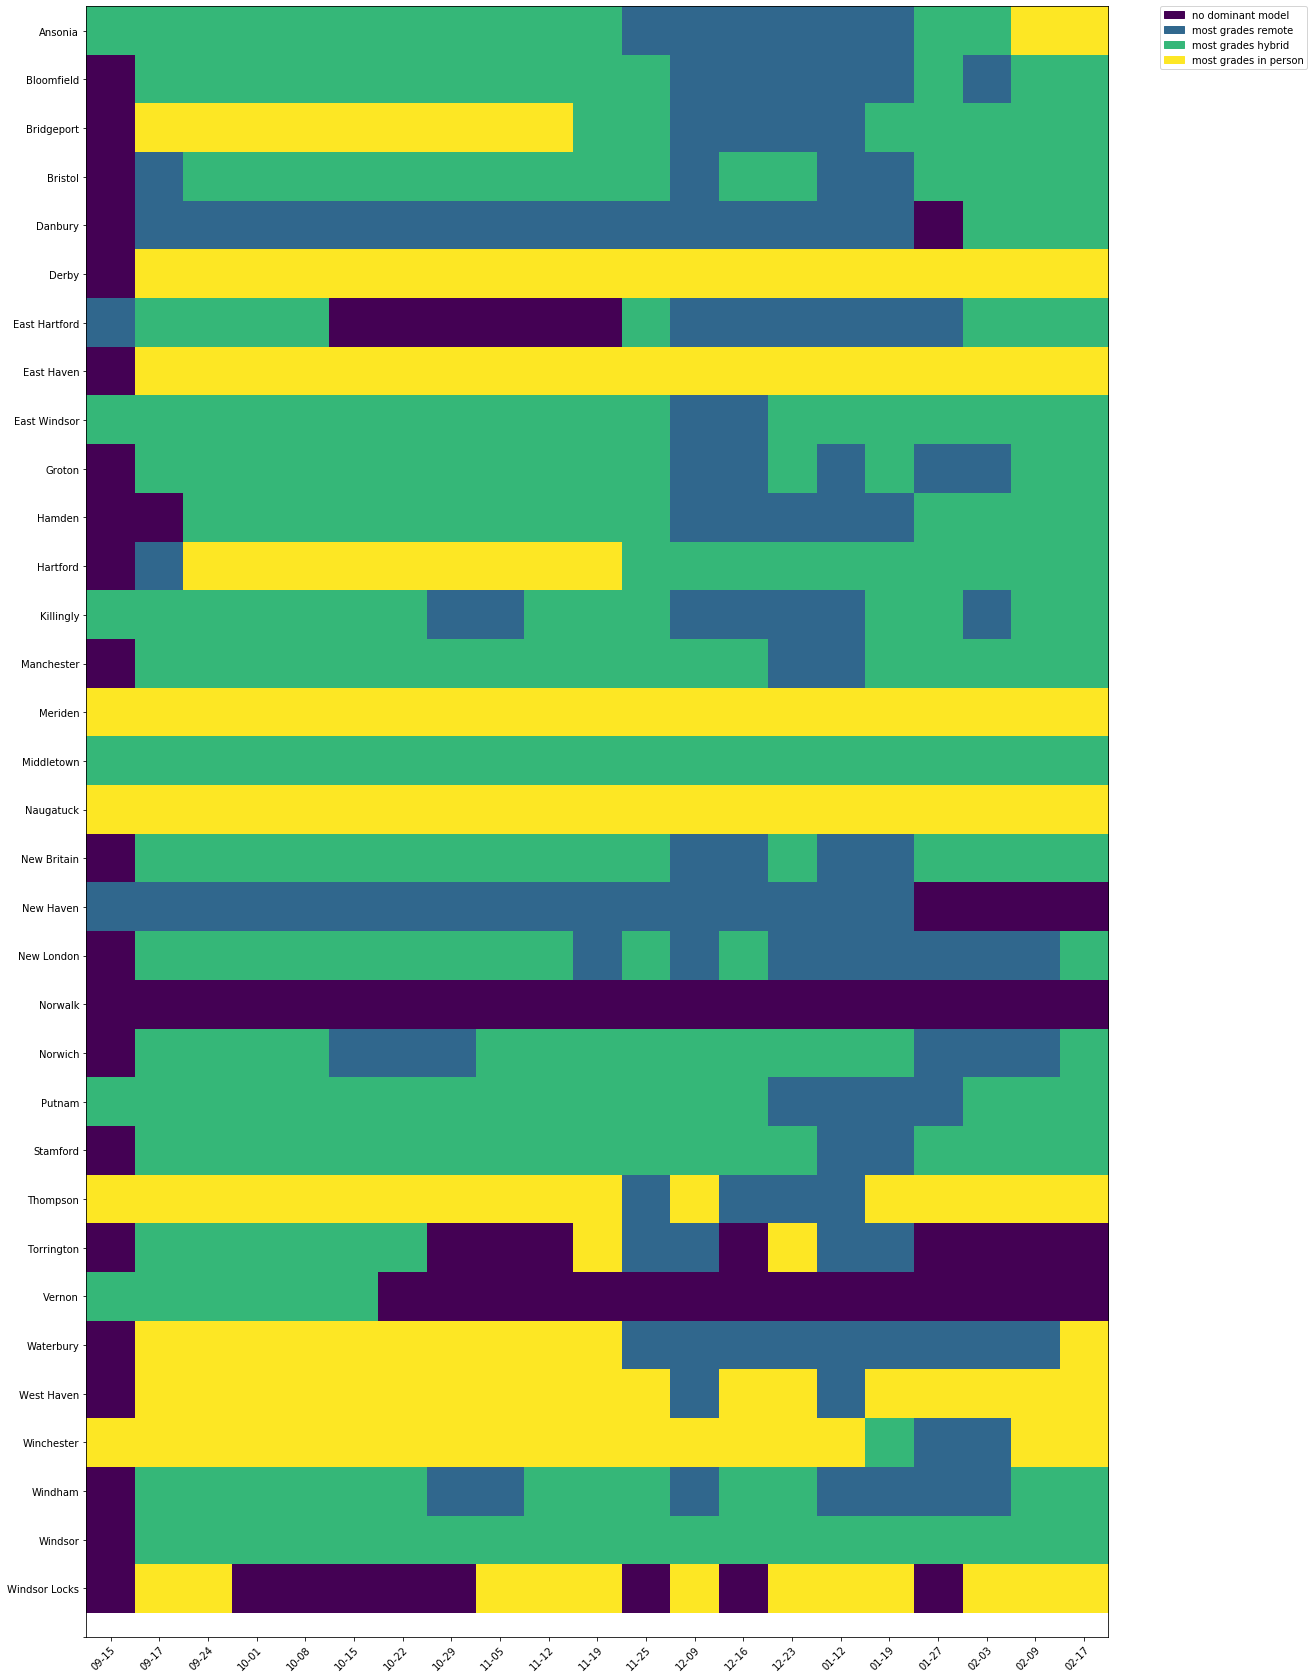

In [9]:

select_graph_export("Alliance")


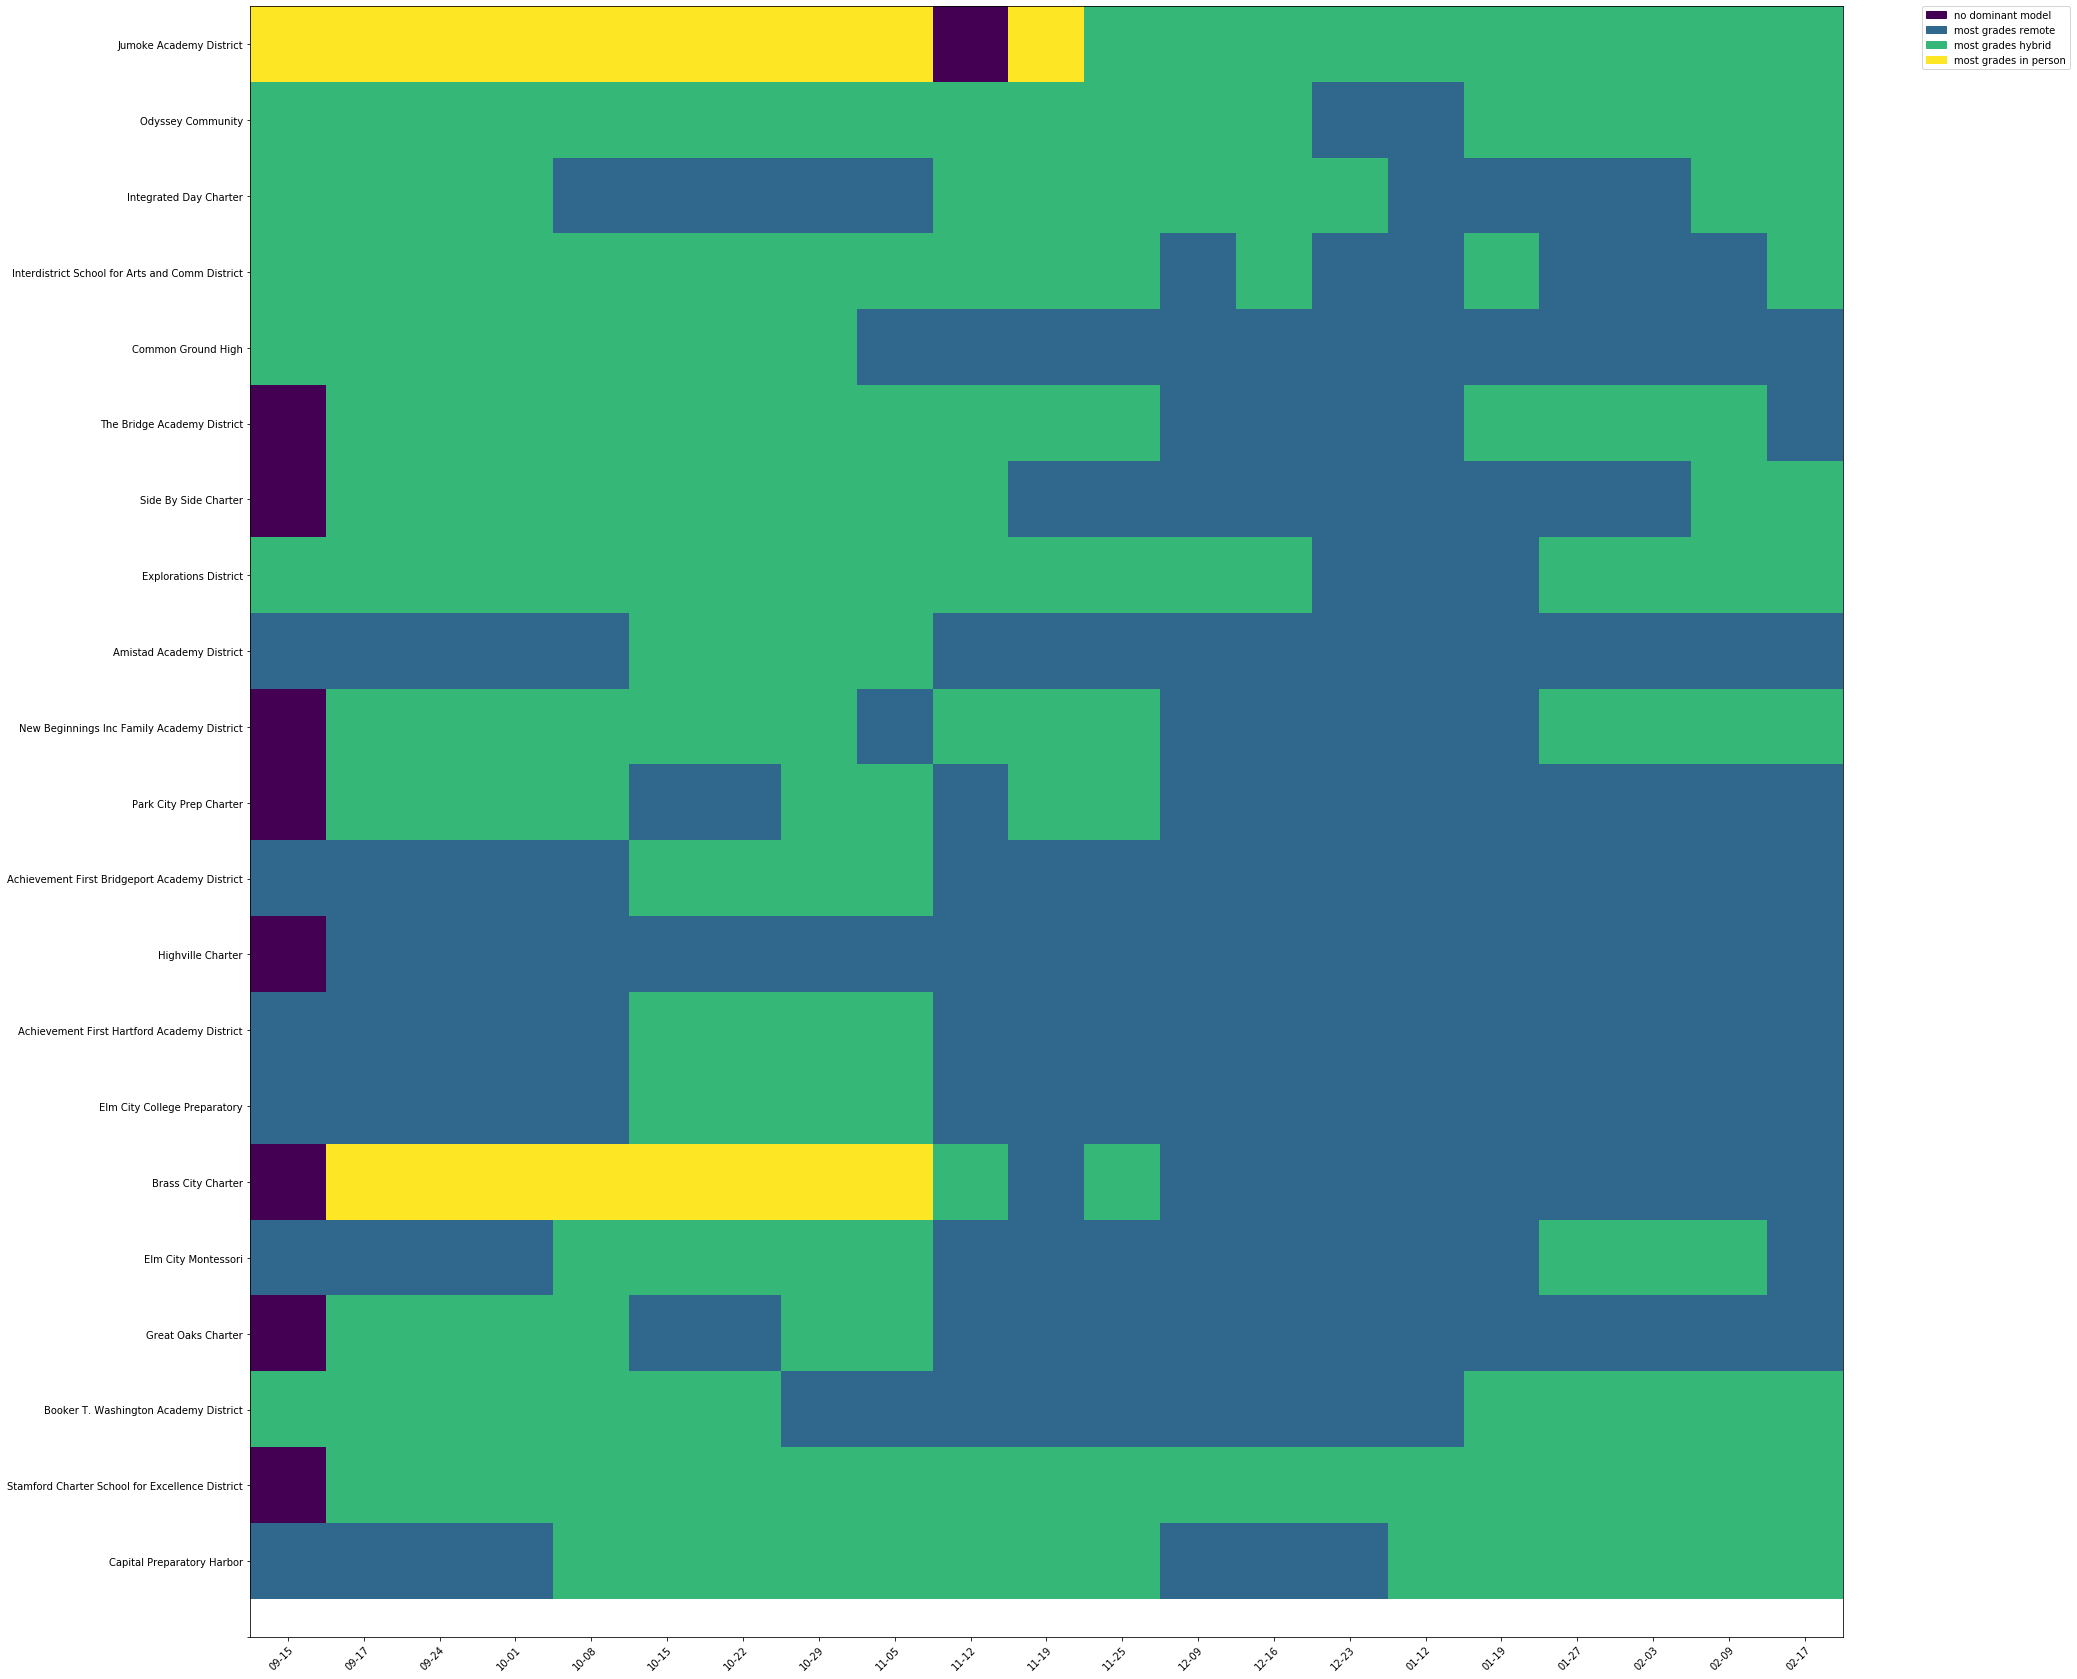

In [10]:
select_graph_export("Charter")

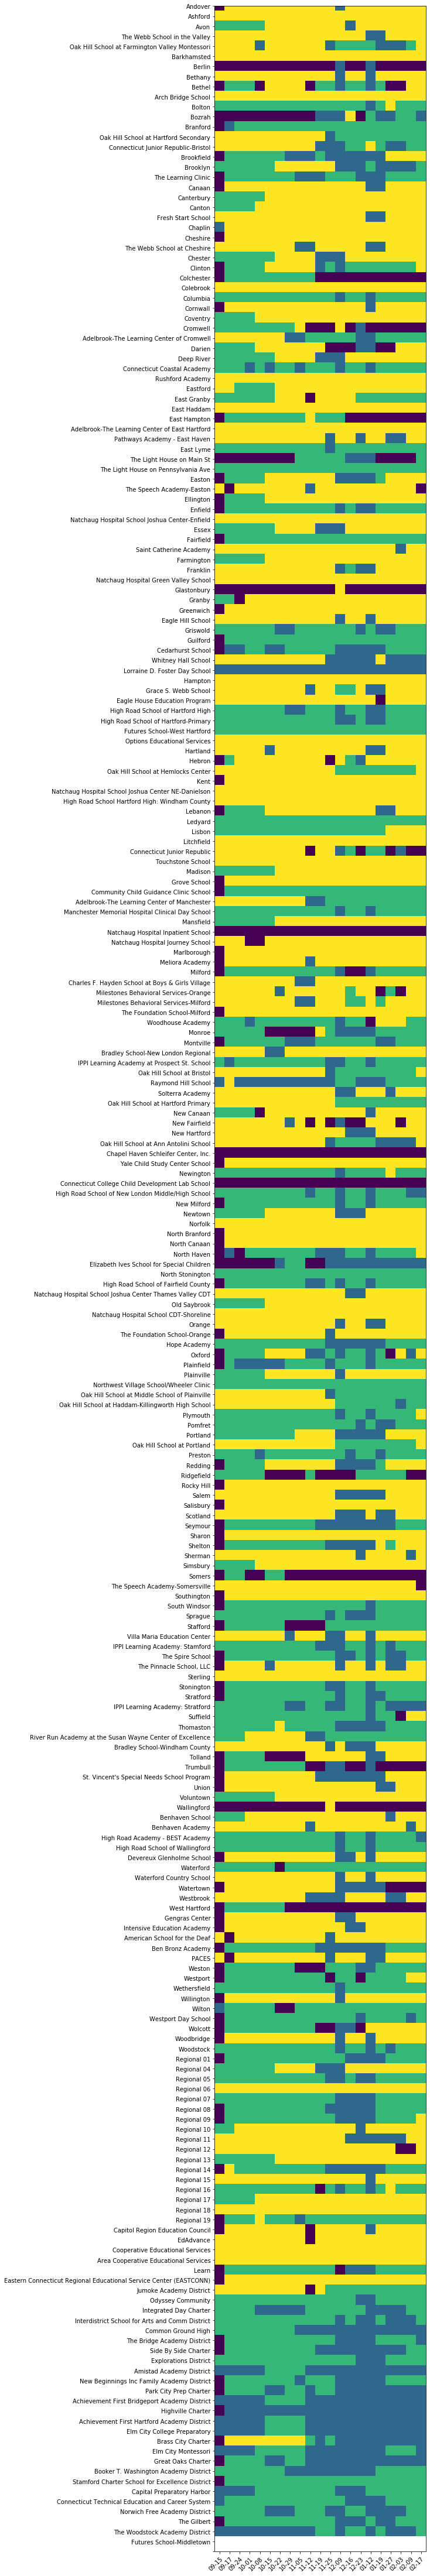

In [31]:
select_graph_export("Non-Alliance")